In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from xgboost import XGBClassifier

# 데이터 처리하기

In [55]:
df = pd.read_csv("data/loan_data.csv")
df

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1


In [56]:
# ----------------------------------------------------
# 2. 나이 및 경력 이상치 제거
# ----------------------------------------------------
# 60세 이상인 데이터 제거
df_preprocessed = df[df['person_age'] <= 60].copy()
print("나이(60세 이상) 제거 후 데이터 개수:", len(df_preprocessed))

# 40년 이상인 경력 데이터 제거
# 나이 제거 후의 데이터프레임을 사용합니다.
df_preprocessed = df_preprocessed[df_preprocessed['person_emp_exp'] <= 40].copy()
print("경력(40년 이상) 제거 후 데이터 개수:", len(df_preprocessed))
print("-" * 30)

# ----------------------------------------------------
# 3. 소득 데이터 처리 및 데이터프레임 저장
# ----------------------------------------------------

# 3-1. 로그 변환만 적용한 데이터프레임 생성
# person_income을 np.log1p로 로그 변환합니다.
df_log_transformed = df_preprocessed.copy()
df_log_transformed['person_income_log'] = np.log1p(df_log_transformed['person_income'])
# 원본 person_income 컬럼은 제거하거나 유지할 수 있습니다. 여기서는 제거합니다.
df_log_transformed = df_log_transformed.drop('person_income', axis=1)

# CSV 파일로 저장
df_log_transformed.to_csv('data/model_data_log.csv', index=False)
print("로그 변환 데이터프레임:")
print(df_log_transformed.head())
print("-" * 30)

# 3-2. 로그 변환 및 캡핑을 적용한 데이터프레임 생성
df_capped = df_preprocessed.copy()

# IQR을 이용해 캡핑 상한선 계산
Q1 = df_capped['person_income'].quantile(0.25)
Q3 = df_capped['person_income'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

# 로그 변환 후 캡핑 적용
df_capped['person_income_log'] = np.log1p(df_capped['person_income'])
df_capped['person_income_log_capped'] = df_capped['person_income_log'].apply(
    lambda x: np.log1p(upper_bound) if np.expm1(x) > upper_bound else x
)
# 원본 person_income 및 로그 변환 컬럼 제거
df_capped = df_capped.drop(['person_income', 'person_income_log'], axis=1)

# CSV 파일로 저장
df_capped.to_csv('data/model_data_capped.csv', index=False)
print("로그 변환 및 캡핑 데이터프레임:")
print(df_capped.head())
print("-" * 30)

print("두 개의 데이터프레임이 각각 'model_data_log.csv'와 'model_data_capped.csv'로 저장되었습니다.")

나이(60세 이상) 제거 후 데이터 개수: 44922
경력(40년 이상) 제거 후 데이터 개수: 44921
------------------------------
로그 변환 데이터프레임:
   person_age person_gender person_education  person_emp_exp  \
0        22.0        female           Master               0   
1        21.0        female      High School               0   
2        25.0        female      High School               3   
3        23.0        female         Bachelor               0   
4        24.0          male           Master               1   

  person_home_ownership  loan_amnt loan_intent  loan_int_rate  \
0                  RENT    35000.0    PERSONAL          16.02   
1                   OWN     1000.0   EDUCATION          11.14   
2              MORTGAGE     5500.0     MEDICAL          12.87   
3                  RENT    35000.0     MEDICAL          15.23   
4                  RENT    35000.0     MEDICAL          14.27   

   loan_percent_income  cb_person_cred_hist_length  credit_score  \
0                 0.49                         3.0 

# 전체 데이터 살펴보기

In [4]:
df = pd.read_csv("data/loan_data.csv")
df

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1


In [5]:
df.isna().sum()

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [7]:
df.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


In [5]:
cat_cols = df.select_dtypes(include='object')
for col in cat_cols:
    print(f"\nUnique values for '{col}':")
    print(df[col].value_counts())


Unique values for 'person_gender':
person_gender
male      24841
female    20159
Name: count, dtype: int64

Unique values for 'person_education':
person_education
Bachelor       13399
Associate      12028
High School    11972
Master          6980
Doctorate        621
Name: count, dtype: int64

Unique values for 'person_home_ownership':
person_home_ownership
RENT        23443
MORTGAGE    18489
OWN          2951
OTHER         117
Name: count, dtype: int64

Unique values for 'loan_intent':
loan_intent
EDUCATION            9153
MEDICAL              8548
VENTURE              7819
PERSONAL             7552
DEBTCONSOLIDATION    7145
HOMEIMPROVEMENT      4783
Name: count, dtype: int64

Unique values for 'previous_loan_defaults_on_file':
previous_loan_defaults_on_file
Yes    22858
No     22142
Name: count, dtype: int64


# 각각의 데이터 살펴보기

In [10]:
plt.rc('font', family='Malgun Gothic')

## person_age

나이는 20~40대에 대부분의 데이터가 몰려 있어서 40세 이상의 데이터는 전부 이상치로 측정됨. 그러나 도메인상 실제 이상한 값은 아님
따라서 60세 이상(94개 데이터) 의 데이터를 날려서 이상치를 제거하고 20~50대 사이의 사람들의 예측 성능을 높이는 방향으로 접근

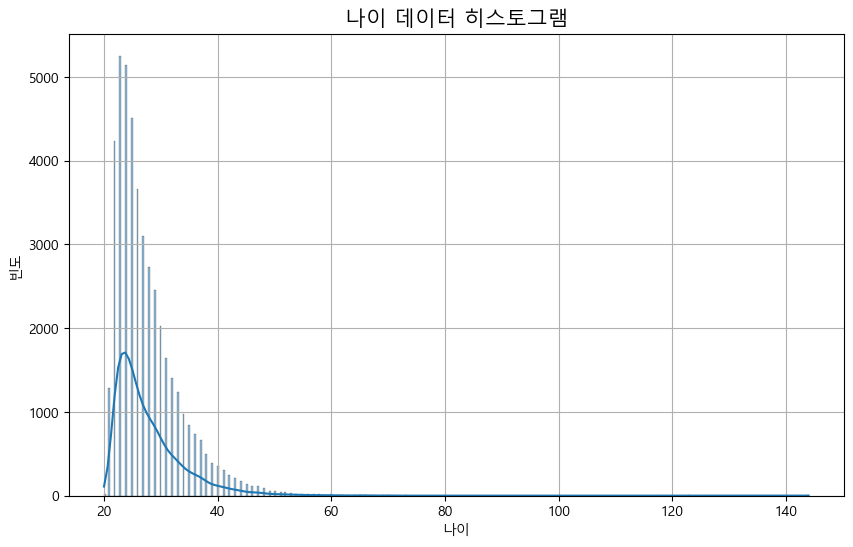

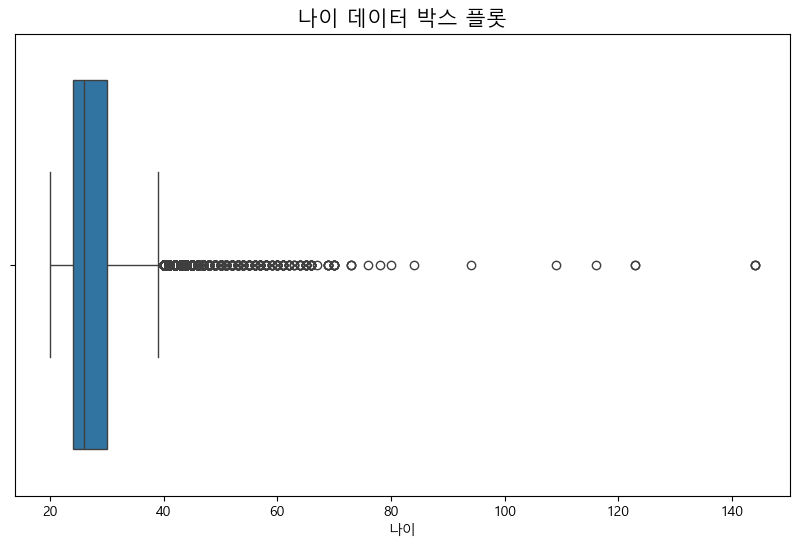

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(df['person_age'], kde=True)
plt.title('나이 데이터 히스토그램', fontsize=15)
plt.xlabel('나이')
plt.ylabel('빈도')
plt.grid(True)
plt.show() # 이미지를 화면에 표시

# 2-2. 박스 플롯: 이상치 확인에 용이
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['person_age'])
plt.title('나이 데이터 박스 플롯', fontsize=15)
plt.xlabel('나이')
plt.show() # 이미지를 화면에 표시

In [12]:
Q1 = df['person_age'].quantile(0.25)
Q3 = df['person_age'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("\nIQR 기준 이상치 분석 결과")
print(f"1사분위수 (Q1): {Q1}")
print(f"3사분위수 (Q3): {Q3}")
print(f"IQR: {IQR}")
print(f"이상치 감지 하한선: {lower_bound}")
print(f"이상치 감지 상한선: {upper_bound}")

# 이상치에 해당하는 데이터 필터링
outliers = df[(df['person_age'] < lower_bound) | (df['person_age'] > upper_bound)]

print("\n감지된 이상치 데이터:")
if outliers.empty:
    print("이상치가 발견되지 않았습니다.")
else:
    print(outliers)


IQR 기준 이상치 분석 결과
1사분위수 (Q1): 24.0
3사분위수 (Q3): 30.0
IQR: 6.0
이상치 감지 하한선: 15.0
이상치 감지 상한선: 39.0

감지된 이상치 데이터:
       person_age person_gender person_education  person_income  \
81          144.0          male         Bachelor       300616.0   
183         144.0          male        Associate       241424.0   
575         123.0        female      High School        97140.0   
747         123.0          male         Bachelor        94723.0   
29120        40.0        female         Bachelor      1440915.0   
...           ...           ...              ...            ...   
44916        42.0        female      High School       100310.0   
44923        47.0          male        Associate        46637.0   
44947        42.0          male        Doctorate       705960.0   
44972        43.0          male        Associate       184295.0   
44977        43.0          male        Associate        22639.0   

       person_emp_exp person_home_ownership  loan_amnt loan_intent  \
81              

In [ ]:
print((df['person_age'] >= 60).sum()) #60 세 이상 데이터 갯수

94


In [ ]:
# # 1. 전체 데이터 개수 확인
# total_rows = len(df)
# print(f"전체 데이터 개수: {total_rows}개")

# # 2. 제거하려는 이상치 데이터 개수 확인 (사용자가 확인한 94개)
# outlier_count = (df['person_age'] >= 60).sum()
# print(f"60세 이상 데이터 개수: {outlier_count}개")

# # 3. 이상치 비율 계산
# outlier_percentage = (outlier_count / total_rows) * 100
# print(f"이상치 데이터 비율: {outlier_percentage:.2f}%")

# # 4. 이상치 제거 실행
# # 60세 이상의 데이터를 이상치로 간주하고 제거합니다.
# # 이 라인을 실행하면 이상치가 제거된 새로운 데이터프레임이 생성됩니다.
# df_temp = df[df['person_age'] < 60].copy()
# print(f"\n이상치 제거 후 데이터 개수: {len(df_tem)}개")

## person_gender

나이 데이터는 별 다른 이상치가, 이상한 분포, 결측치 등이 없음. 그냥 사용하는 것으로 결정

In [20]:
gender_counts = df['person_gender'].value_counts(dropna=False)
print("성별 데이터의 빈도수 및 결측치:")
print(gender_counts)
print("-" * 30)

# 2-2. 성별 비율 확인
total_genders = gender_counts.sum()
gender_percentage = (gender_counts / total_genders) * 100
print("성별 데이터의 비율 (%):")
print(gender_percentage)
print("-" * 30)

성별 데이터의 빈도수 및 결측치:
person_gender
male      24841
female    20159
Name: count, dtype: int64
------------------------------
성별 데이터의 비율 (%):
person_gender
male      55.202222
female    44.797778
Name: count, dtype: float64
------------------------------


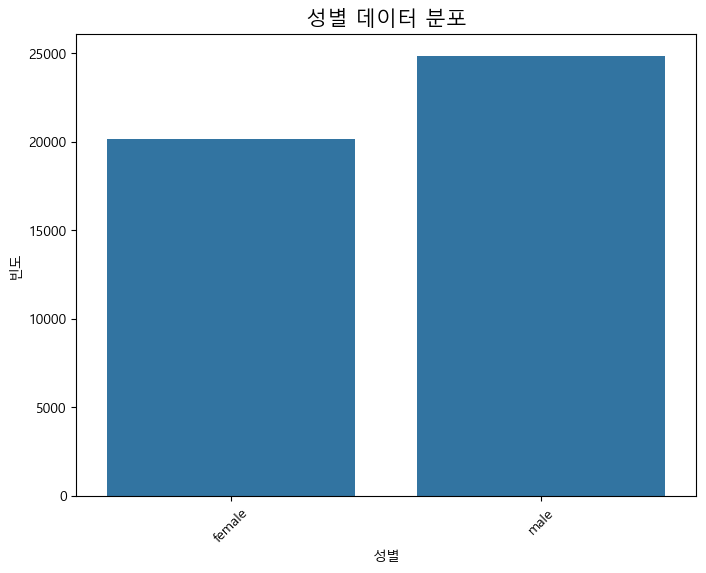

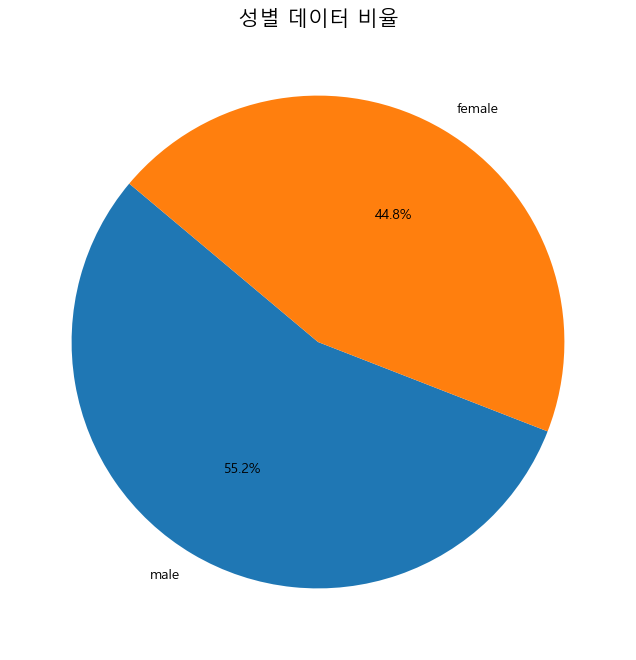

In [22]:
# 3-1. 막대 그래프 (Bar Chart)
plt.figure(figsize=(8, 6))
sns.countplot(x='person_gender', data=df)
plt.title('성별 데이터 분포', fontsize=15)
plt.xlabel('성별')
plt.ylabel('빈도')
plt.xticks(rotation=45) # 라벨 회전
plt.show()

# 3-2. 파이 차트 (Pie Chart) - 비율 확인에 용이
plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('성별 데이터 비율', fontsize=15)
plt.show()

## person_education

특별한 이상치 없이 5개의 분류 안의 값들을 가짐. 추가적인 처리 안함.

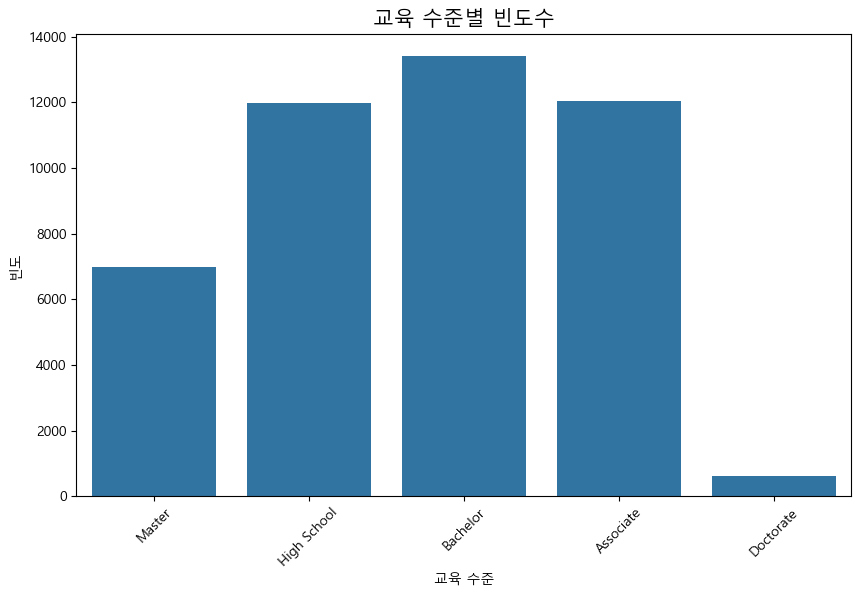

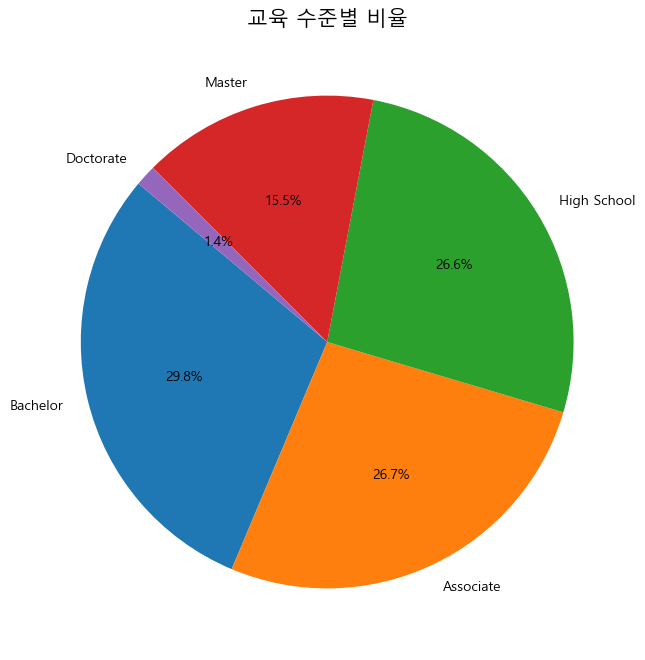

In [23]:
# 3-1. 막대 그래프: 빈도수 확인
plt.figure(figsize=(10, 6))
sns.countplot(x='person_education', data=df)
plt.title('교육 수준별 빈도수', fontsize=15)
plt.xlabel('교육 수준')
plt.ylabel('빈도')
plt.xticks(rotation=45)
plt.show()

# 3-2. 파이 차트: 비율 확인 (결측치 제외)
education_counts = df['person_education'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(education_counts, labels=education_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('교육 수준별 비율', fontsize=15)
plt.show()

## person_income

소득이 매우 높거나, 낮은 사람이 끝쪽에 분포함. 일단 이에 대해서 로그 변환을 하고, 특정 값 이상의 값을 전부 한 개로 변환하는 capped를 적용
이 부분은 로그 변환만 한 것과 , capped 한 모델의 정확도 차이를 분석하는 것도 좋을 듯 하다.

In [27]:
df['person_income'].describe()

count    4.500000e+04
mean     8.031905e+04
std      8.042250e+04
min      8.000000e+03
25%      4.720400e+04
50%      6.704800e+04
75%      9.578925e+04
max      7.200766e+06
Name: person_income, dtype: float64

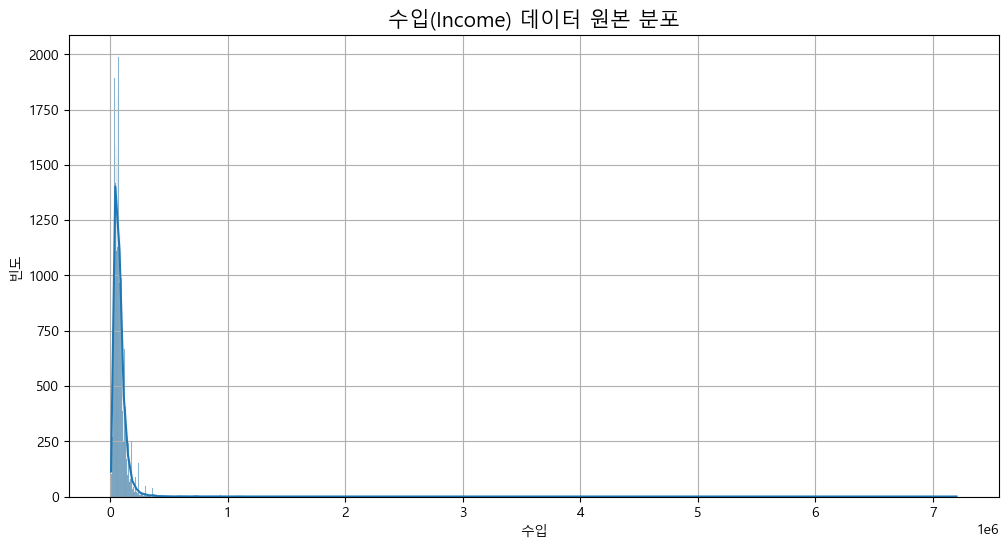

In [24]:
plt.figure(figsize=(12, 6))
sns.histplot(df['person_income'], kde=True)
plt.title('수입(Income) 데이터 원본 분포', fontsize=15)
plt.xlabel('수입')
plt.ylabel('빈도')
plt.grid(True)
plt.show()

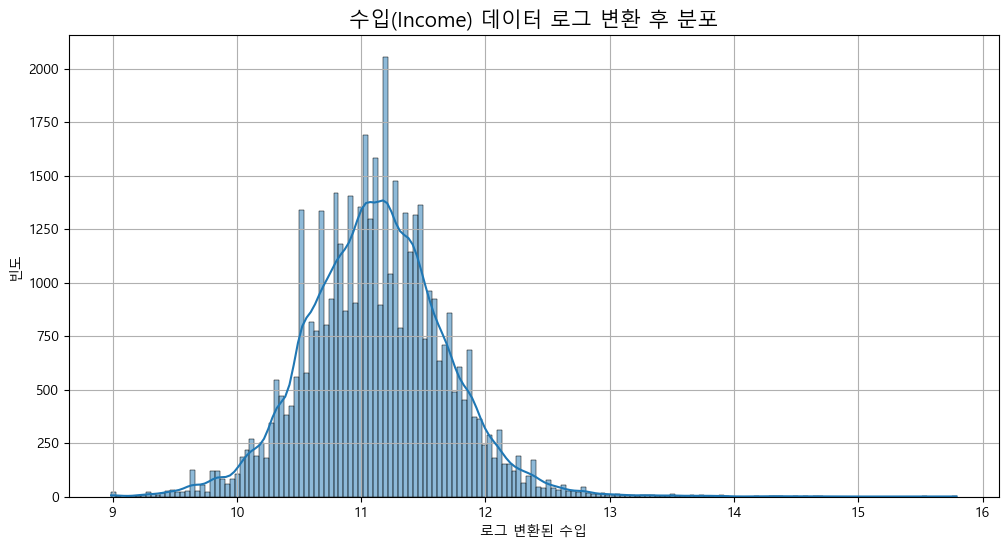

In [25]:
# ----------------------------------------------------
# 4. 로그 변환 적용
# ----------------------------------------------------
# 로그 변환 시 0이하의 값은 오류를 발생시키므로, 0에 가까운 작은 값을 더해줍니다.
# np.log1p() 함수를 사용하면 np.log(1+x)와 동일하며, 0에 대한 오류를 방지합니다.
df['log_income'] = np.log1p(df['person_income'])

# ----------------------------------------------------
# 5. 데이터 분포 시각화 (로그 변환 후)
# ----------------------------------------------------
plt.figure(figsize=(12, 6))
sns.histplot(df['log_income'], kde=True)
plt.title('수입(Income) 데이터 로그 변환 후 분포', fontsize=15)
plt.xlabel('로그 변환된 수입')
plt.ylabel('빈도')
plt.grid(True)
plt.show()

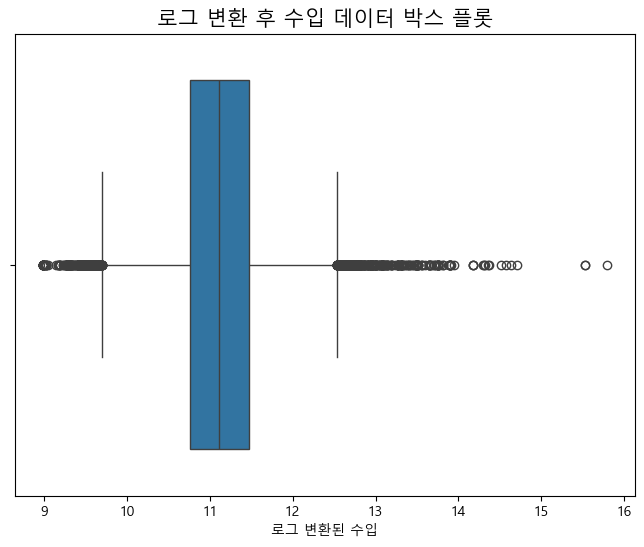

In [26]:
# ----------------------------------------------------
# 6. 박스 플롯을 이용한 이상치 확인
# ----------------------------------------------------
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['log_income'])
plt.title('로그 변환 후 수입 데이터 박스 플롯', fontsize=15)
plt.xlabel('로그 변환된 수입')
plt.show()

In [28]:
# ----------------------------------------------------
# 7. IQR을 이용한 이상치 개수 확인 (추가된 코드)
# ----------------------------------------------------
Q1 = df['log_income'].quantile(0.25)
Q3 = df['log_income'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치에 해당하는 데이터 개수 확인
outlier_count = df[(df['log_income'] < lower_bound) | (df['log_income'] > upper_bound)].shape[0]

print("\n로그 변환된 수입 데이터의 이상치 분석 결과")
print(f"이상치 감지 하한선: {lower_bound:.2f}")
print(f"이상치 감지 상한선: {upper_bound:.2f}")
print(f"\n이상치 데이터 개수: {outlier_count}개")

# 이상치 데이터 확인
outliers = df[(df['log_income'] < lower_bound) | (df['log_income'] > upper_bound)]
print("\n감지된 이상치 데이터:")
if outliers.empty:
    print("이상치가 발견되지 않았습니다.")
else:
    print(outliers)


로그 변환된 수입 데이터의 이상치 분석 결과
이상치 감지 하한선: 9.70
이상치 감지 상한선: 12.53

이상치 데이터 개수: 798개

감지된 이상치 데이터:
       person_age person_gender person_education  person_income  \
1            21.0        female      High School        12282.0   
2            25.0        female      High School        12438.0   
5            21.0        female      High School        12951.0   
9            21.0        female      High School        12739.0   
11           21.0        female        Associate        13113.0   
...           ...           ...              ...            ...   
44856        26.0          male         Bachelor        15393.0   
44881        22.0        female      High School        15244.0   
44922        29.0          male           Master       726416.0   
44929        25.0        female         Bachelor        13201.0   
44947        42.0          male        Doctorate       705960.0   

       person_emp_exp person_home_ownership  loan_amnt      loan_intent  \
1                   0      


캡핑 후 데이터 확인:
   person_income  log_income  log_income_capped
0        71948.0   11.183713          11.183713
1        12282.0    9.415971           9.415971
2        12438.0    9.428592           9.428592
3        79753.0   11.286702          11.286702
4        66135.0   11.099469          11.099469
------------------------------


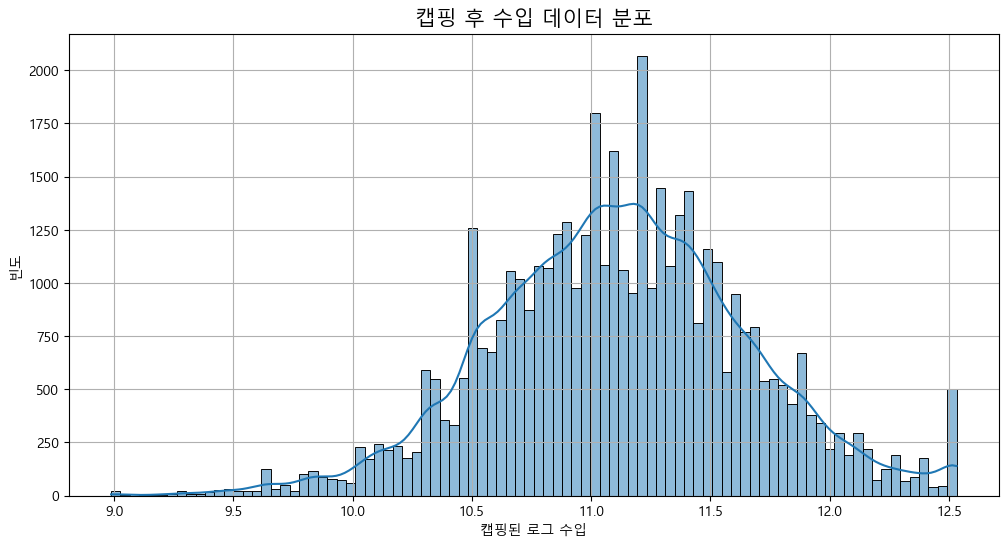

In [29]:
# 이상치 처리: 캡핑(Capping)
# 이상치 데이터를 상한선 값으로 대체합니다.
df['log_income_capped'] = df['log_income'].apply(
    lambda x: upper_bound if x > upper_bound else x
)

print("\n캡핑 후 데이터 확인:")
print(df[['person_income', 'log_income', 'log_income_capped']].head())
print("-" * 30)

# 캡핑 후 분포 재확인
plt.figure(figsize=(12, 6))
sns.histplot(df['log_income_capped'], kde=True)
plt.title('캡핑 후 수입 데이터 분포', fontsize=15)
plt.xlabel('캡핑된 로그 수입')
plt.ylabel('빈도')
plt.grid(True)
plt.show()


로그 변환된 수입 데이터의 이상치 그룹 'loan_status' 분포:
loan_status
0    431
1    367
Name: count, dtype: int64
------------------------------


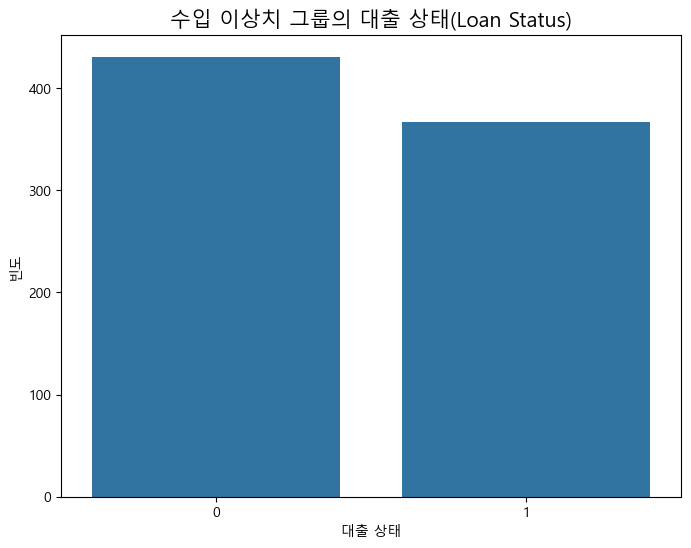

In [30]:
# ----------------------------------------------------
# 8. 이상치 그룹의 'loan_status' 분석 (추가된 코드)
# ----------------------------------------------------
print("\n로그 변환된 수입 데이터의 이상치 그룹 'loan_status' 분포:")
if not outliers.empty:
    loan_status_counts = outliers['loan_status'].value_counts()
    print(loan_status_counts)
    print("-" * 30)
    
    # 이상치 그룹의 'loan_status' 막대 그래프 시각화
    plt.figure(figsize=(8, 6))
    sns.countplot(x='loan_status', data=outliers)
    plt.title('수입 이상치 그룹의 대출 상태(Loan Status)', fontsize=15)
    plt.xlabel('대출 상태')
    plt.ylabel('빈도')
    plt.show()
else:
    print("이상치가 없어 'loan_status'를 분석할 수 없습니다.")

## person_emp_exp

경력 데이터도 나이와 마찬가지로 경력이 매우 긴, 100년 이상 인 소수의 데이터가 존재한다. 이 경우 나이를 60세로 끊었으니, 취업 경력도 20세 부터 40년으로 끊어서 활용할 생각
45000개 중 75개가 날아감.


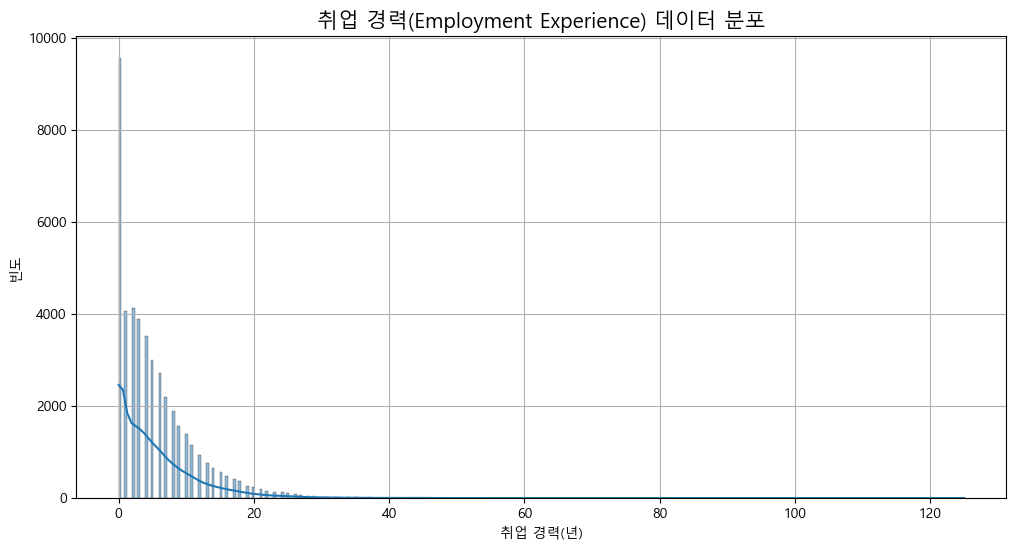

In [31]:
# ----------------------------------------------------
# 3. 데이터 분포 시각화 (히스토그램)
# ----------------------------------------------------
plt.figure(figsize=(12, 6))
sns.histplot(df['person_emp_exp'], kde=True)
plt.title('취업 경력(Employment Experience) 데이터 분포', fontsize=15)
plt.xlabel('취업 경력(년)')
plt.ylabel('빈도')
plt.grid(True)
plt.show()

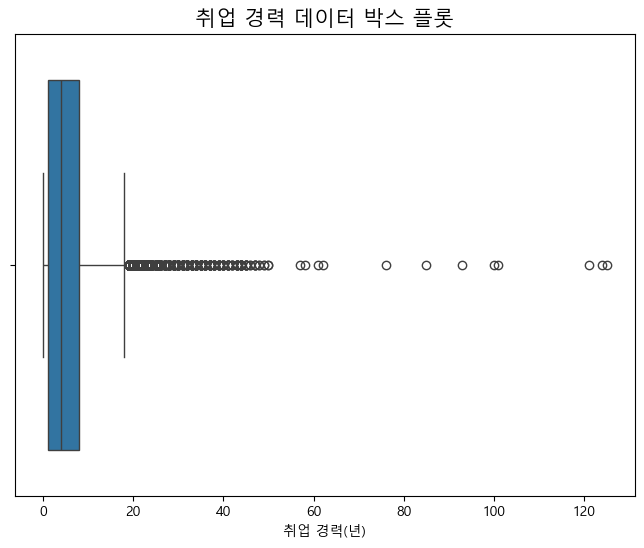

In [32]:
# ----------------------------------------------------
# 4. 이상치 확인 (박스 플롯)
# ----------------------------------------------------
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['person_emp_exp'])
plt.title('취업 경력 데이터 박스 플롯', fontsize=15)
plt.xlabel('취업 경력(년)')
plt.show()

In [33]:
# ----------------------------------------------------
# 5. 이상치 및 논리적 오류 데이터 확인
# ----------------------------------------------------
# IQR을 이용한 통계적 이상치 감지
Q1 = df['person_emp_exp'].quantile(0.25)
Q3 = df['person_emp_exp'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치에 해당하는 데이터 필터링
outliers_iqr = df[(df['person_emp_exp'] < lower_bound) | (df['person_emp_exp'] > upper_bound)]

print("IQR 기준으로 감지된 이상치 데이터:")
if outliers_iqr.empty:
    print("이상치가 발견되지 않았습니다.")
else:
    print(outliers_iqr)
print("-" * 30)

# 논리적 오류 확인: 경력이 나이보다 많은 경우
logical_errors = df[df['person_emp_exp'] > df['person_age']]
print("경력이 나이보다 많은 논리적 오류 데이터:")
if logical_errors.empty:
    print("논리적 오류가 발견되지 않았습니다.")
else:
    print(logical_errors)

IQR 기준으로 감지된 이상치 데이터:
       person_age person_gender person_education  person_income  \
81          144.0          male         Bachelor       300616.0   
183         144.0          male        Associate       241424.0   
575         123.0        female      High School        97140.0   
747         123.0          male         Bachelor        94723.0   
29120        40.0        female         Bachelor      1440915.0   
...           ...           ...              ...            ...   
44916        42.0        female      High School       100310.0   
44923        47.0          male        Associate        46637.0   
44947        42.0          male        Doctorate       705960.0   
44972        43.0          male        Associate       184295.0   
44977        43.0          male        Associate        22639.0   

       person_emp_exp person_home_ownership  loan_amnt loan_intent  \
81                125                  RENT     4800.0     VENTURE   
183               121            

In [35]:
print((df['person_emp_exp'] >= 40).sum()) # 경력 40년 이상

73


In [ ]:
# # ----------------------------------------------------
# # 6. 이상치 제거
# # ----------------------------------------------------
# # 논리적 오류를 포함한 이상치를 제거합니다.
# # 이 라인을 실행하면 이상치 및 논리적 오류가 제거된 새로운 데이터프레임이 생성됩니다.
# df_cleaned = df[df['person_emp_exp'] <= upper_bound].copy()
# df_cleaned = df_cleaned[df_cleaned['person_emp_exp'] <= df_cleaned['person_age']].copy()

# print("\n이상치 및 논리적 오류 제거 후 데이터 개수:")
# print(f"원본 데이터 개수: {len(df)}개")
# print(f"이상치 제거 후 데이터 개수: {len(df_cleaned)}개")

## person_home_ownership

주택 소유 상태는 특별한 이상치가 없어서 유지하기로 결정
other 에 대해서 매우 소수의 값이어서 제거할까 고민했지만, 데이터 자체가 그런 값을 원래 가지고 있었다면 굳이 데이터의 손실을 감수할 필요는 없다고 판단.
또한 other에 대해서 대출 거부가 2배 이상 높았기에, 데이터를 유지하기로 결정

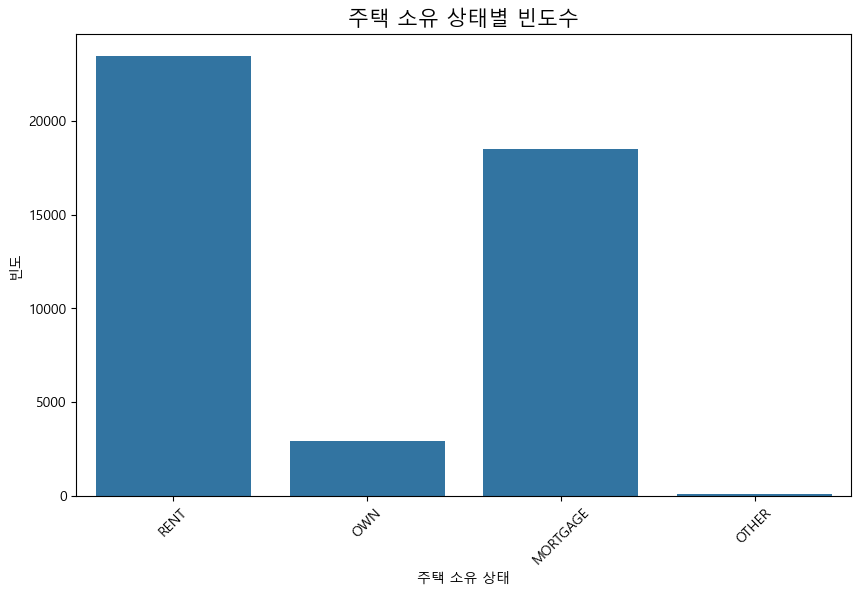

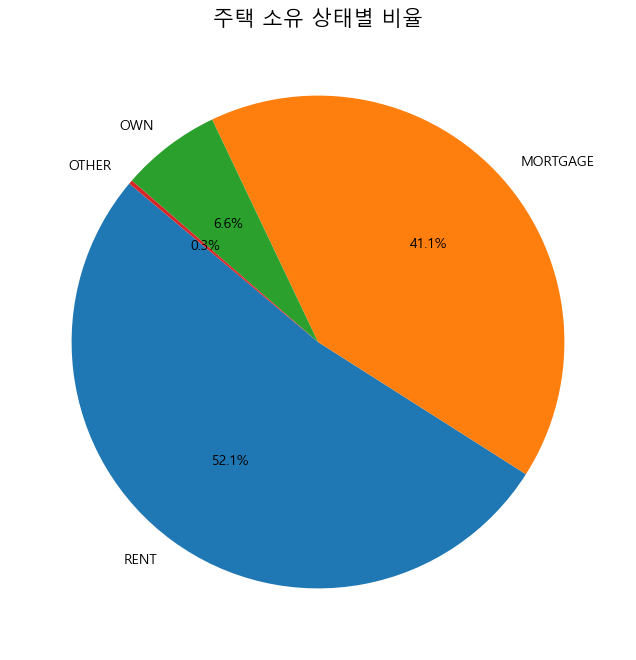

In [37]:
# 3-1. 막대 그래프: 빈도수 확인
plt.figure(figsize=(10, 6))
sns.countplot(x='person_home_ownership', data=df)
plt.title('주택 소유 상태별 빈도수', fontsize=15)
plt.xlabel('주택 소유 상태')
plt.ylabel('빈도')
plt.xticks(rotation=45)
plt.show()

# 3-2. 파이 차트: 비율 확인
ownership_counts = df['person_home_ownership'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(ownership_counts, labels=ownership_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('주택 소유 상태별 비율', fontsize=15)
plt.show()


'OTHER' 범주 데이터의 loan_status 분포:
loan_status
0    78
1    39
Name: count, dtype: int64
------------------------------


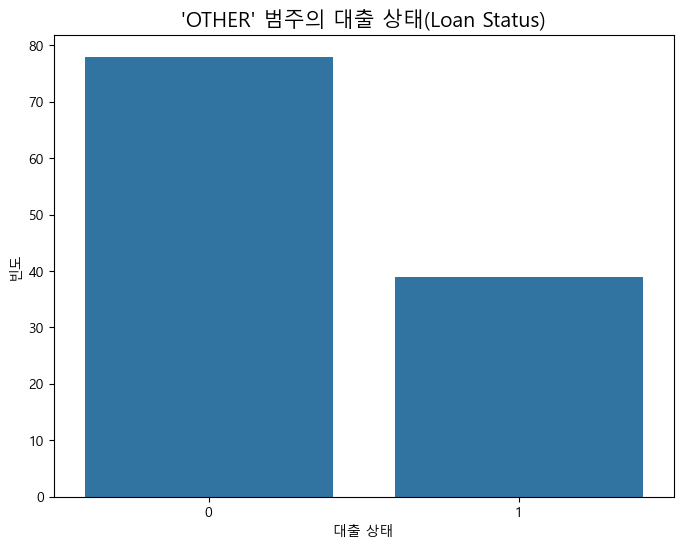

In [38]:
# ----------------------------------------------------
# 4. 'OTHER' 범주의 loan_status 분석 (추가된 코드)
# ----------------------------------------------------
print("\n'OTHER' 범주 데이터의 loan_status 분포:")
# 'OTHER' 범주에 해당하는 행만 필터링
other_df = df[df['person_home_ownership'] == 'OTHER']
if not other_df.empty:
    loan_status_counts = other_df['loan_status'].value_counts()
    print(loan_status_counts)
    print("-" * 30)
    
    # 막대 그래프 시각화
    plt.figure(figsize=(8, 6))
    sns.countplot(x='loan_status', data=other_df)
    plt.title("'OTHER' 범주의 대출 상태(Loan Status)", fontsize=15)
    plt.xlabel('대출 상태')
    plt.ylabel('빈도')
    plt.show()
else:
    print("'OTHER' 범주 데이터가 없어 분석할 수 없습니다.")

## loan_amnt

대출 금액은 소득과 달리 꼬리가 긴 분포가 아니라, 봉우리가 여러개 있는 분포이다. 따라서 로그 변환은 필요하지 않다고 판단.
또한 이상치를 계산해보면 23000 이상의 대출 금액은 이상치라고 되어있는데, 그래프의 분포나, 도메인 생각해 보면 이상치라기 보다는 그만큼 대출하는 사람이 많지 않은 것일 뿐 틀린 값은 아니라고 생각됨.
또한 많은 금액을 대출받고자하는 사람의 특성 또한 있을 것이라고 판단하여 추가적인 처리는 하지 않는 것으로 결정

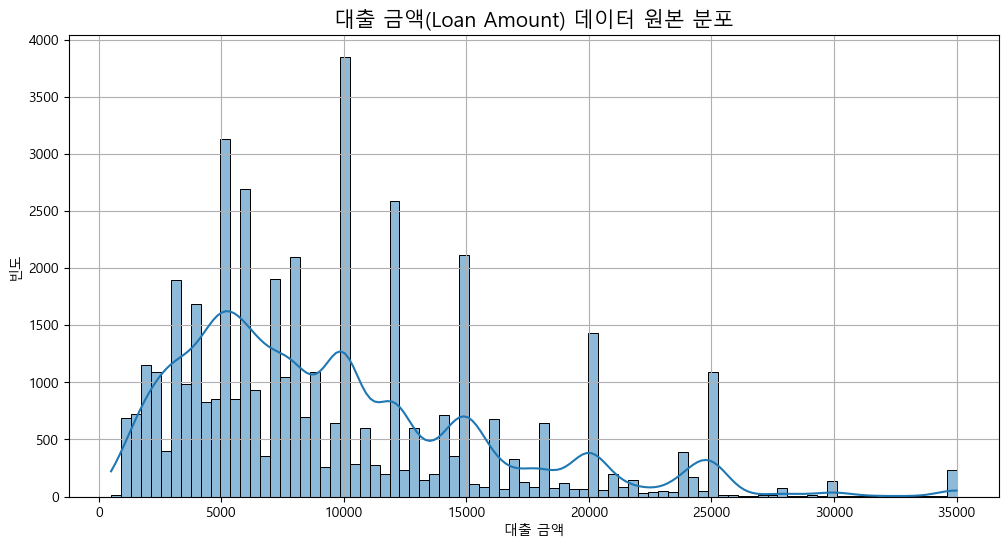

In [39]:
# ----------------------------------------------------
# 3. 데이터 분포 시각화 (원본)
# ----------------------------------------------------
plt.figure(figsize=(12, 6))
sns.histplot(df['loan_amnt'], kde=True)
plt.title('대출 금액(Loan Amount) 데이터 원본 분포', fontsize=15)
plt.xlabel('대출 금액')
plt.ylabel('빈도')
plt.grid(True)
plt.show()

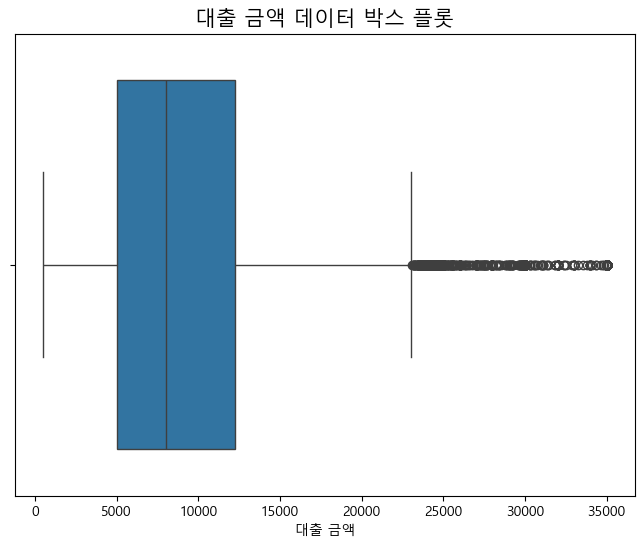

In [40]:
# ----------------------------------------------------
# 5. 박스 플롯을 이용한 이상치 확인
# ----------------------------------------------------
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['loan_amnt'])
plt.title('대출 금액 데이터 박스 플롯', fontsize=15)
plt.xlabel('대출 금액')
plt.show()

In [42]:
df['loan_amnt'].describe()

count    45000.000000
mean      9583.157556
std       6314.886691
min        500.000000
25%       5000.000000
50%       8000.000000
75%      12237.250000
max      35000.000000
Name: loan_amnt, dtype: float64

In [41]:
# ----------------------------------------------------
# 6. IQR을 이용한 이상치 개수 확인 및 처리
# ----------------------------------------------------
Q1 = df['loan_amnt'].quantile(0.25)
Q3 = df['loan_amnt'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치에 해당하는 데이터 개수 확인
outlier_count = df[(df['loan_amnt'] < lower_bound) | (df['loan_amnt'] > upper_bound)].shape[0]

print("\n대출 금액 데이터의 이상치 분석 결과")
print(f"이상치 감지 하한선: {lower_bound:.2f}")
print(f"이상치 감지 상한선: {upper_bound:.2f}")
print(f"\n이상치 데이터 개수: {outlier_count}개")

# 이상치 데이터 확인
outliers = df[(df['loan_amnt'] < lower_bound) | (df['loan_amnt'] > upper_bound)]
print("\n감지된 이상치 데이터:")
if outliers.empty:
    print("이상치가 발견되지 않았습니다.")
else:
    print(outliers)


대출 금액 데이터의 이상치 분석 결과
이상치 감지 하한선: -5855.88
이상치 감지 상한선: 23093.12

이상치 데이터 개수: 2348개

감지된 이상치 데이터:
       person_age person_gender person_education  person_income  \
0            22.0        female           Master        71948.0   
3            23.0        female         Bachelor        79753.0   
4            24.0          male           Master        66135.0   
6            26.0        female         Bachelor        93471.0   
7            24.0        female      High School        95550.0   
...           ...           ...              ...            ...   
44922        29.0          male           Master       726416.0   
44944        26.0          male        Associate        97590.0   
44952        23.0        female        Associate        72843.0   
44970        26.0        female         Bachelor        84780.0   
44972        43.0          male        Associate       184295.0   

       person_emp_exp person_home_ownership  loan_amnt        loan_intent  \
0                   0

## loan_intent

각 범주의 분포가 고르고, 특별한 결측치 또한 존재하지 않음. 별 다른 처리 없이 넘어가도 괜찮을 듯

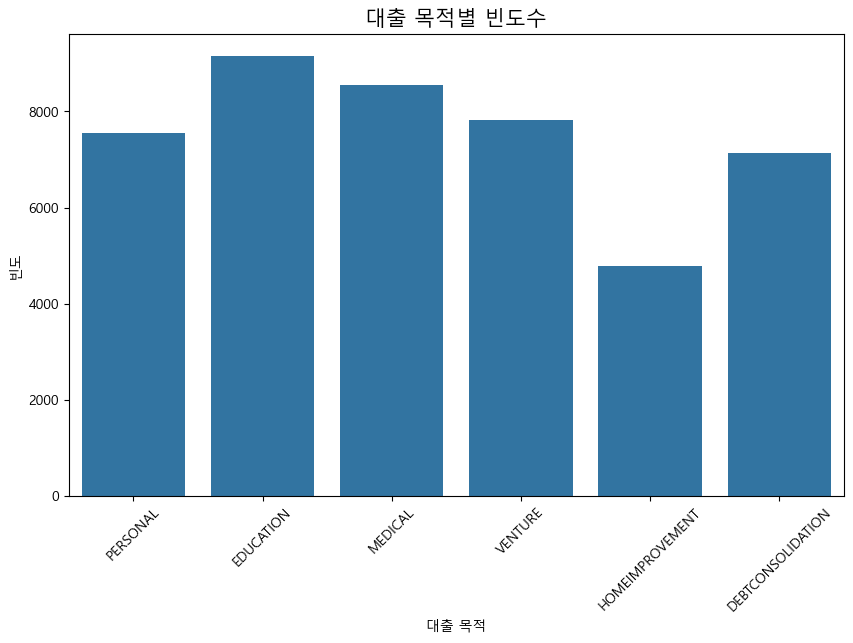

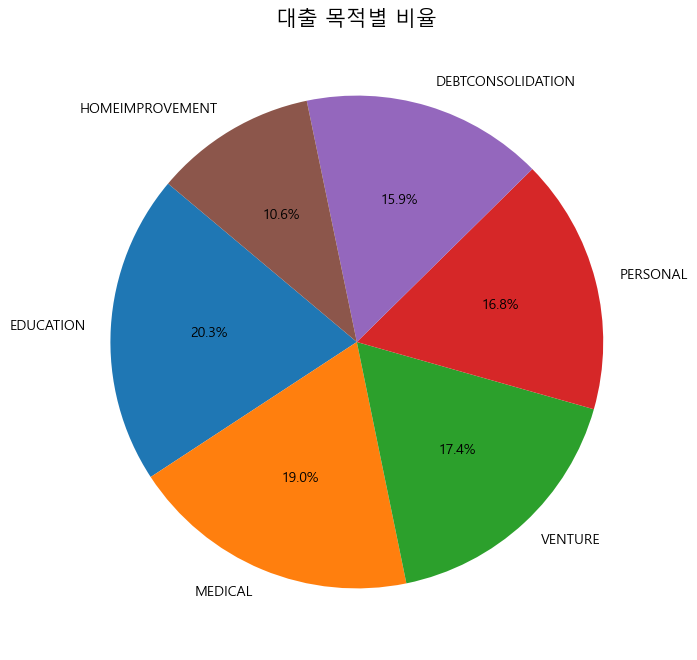

In [43]:
# 3-1. 막대 그래프: 빈도수 확인
plt.figure(figsize=(10, 6))
sns.countplot(x='loan_intent', data=df)
plt.title('대출 목적별 빈도수', fontsize=15)
plt.xlabel('대출 목적')
plt.ylabel('빈도')
plt.xticks(rotation=45)
plt.show()

# 3-2. 파이 차트: 비율 확인
loan_intent_counts = df['loan_intent'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(loan_intent_counts, labels=loan_intent_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('대출 목적별 비율', fontsize=15)
plt.show()

## loan_int_rate

대출 이자율 관련 특성, 비 정상적으로 높은 수치는 존재하지 않고, 이상치로 특정되는 것도 구간에서 그리 멀리 떨어져 있지는 않음. 또한 이상치 중 대출 불가에서의 이상치는 대출 가능에서는 이상치 범위에 들지 않기에, 제거가 필요하지는 않다고 판단됨.

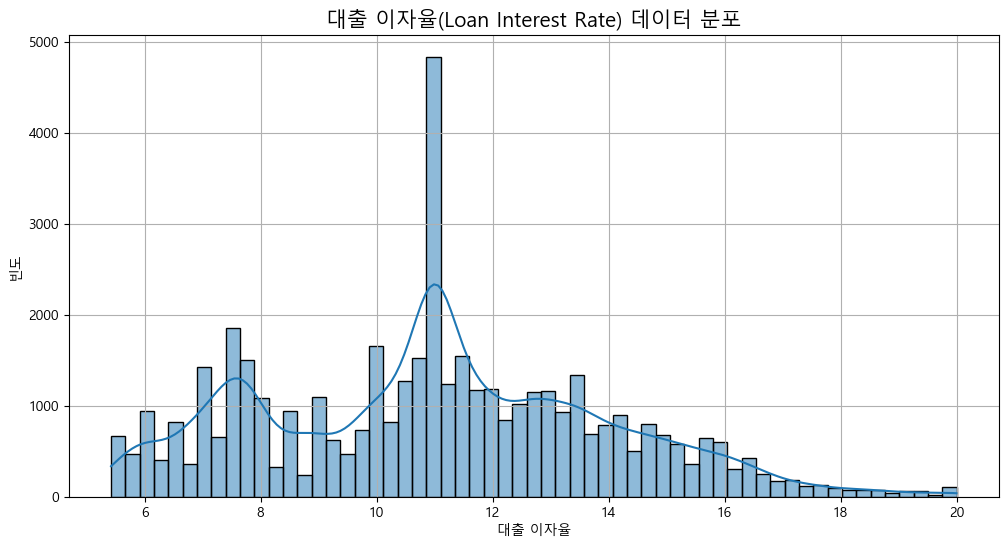

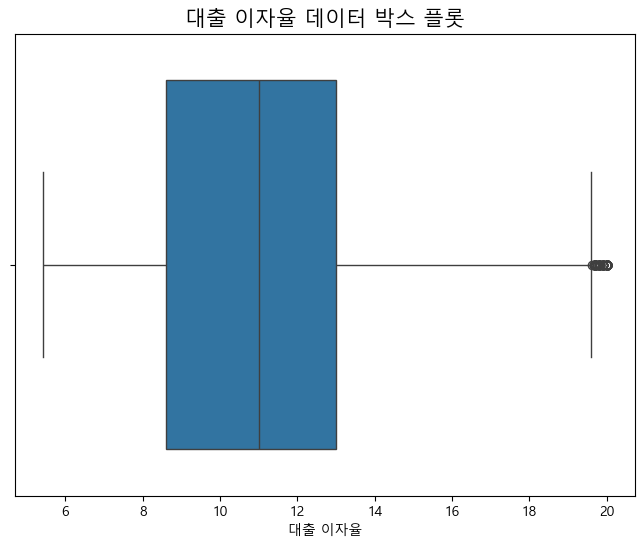

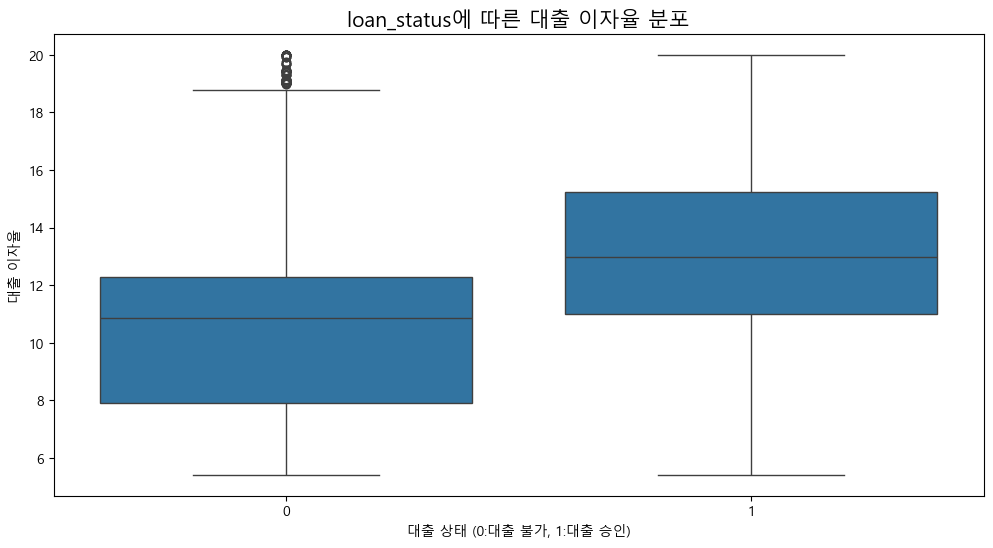

In [44]:
# ----------------------------------------------------
# 3. 데이터 분포 시각화 (히스토그램)
# ----------------------------------------------------
plt.figure(figsize=(12, 6))
sns.histplot(df['loan_int_rate'], kde=True)
plt.title('대출 이자율(Loan Interest Rate) 데이터 분포', fontsize=15)
plt.xlabel('대출 이자율')
plt.ylabel('빈도')
plt.grid(True)
plt.show()

# ----------------------------------------------------
# 4. 이상치 확인 (박스 플롯)
# ----------------------------------------------------
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['loan_int_rate'])
plt.title('대출 이자율 데이터 박스 플롯', fontsize=15)
plt.xlabel('대출 이자율')
plt.show()

# ----------------------------------------------------
# 5. loan_status 와의 관계 시각화
# ----------------------------------------------------
plt.figure(figsize=(12, 6))
sns.boxplot(x='loan_status', y='loan_int_rate', data=df)
plt.title('loan_status에 따른 대출 이자율 분포', fontsize=15)
plt.xlabel('대출 상태 (0:대출 불가, 1:대출 승인)')
plt.ylabel('대출 이자율')
plt.show()

대출 가능에서 이자율 분포가 더 높게 나왔다는 것은, 이자율이 높을 수록 대출을 더 많이 해 주었다는 의미?

## loan_percent_income

특별한 이상치가 있다고 판단하지 않음. 통계적 이상치가 있으나, 현실적으로 불가능한 느낌은 아니라고 생각됨? -> 이 특성에 대해서는 좀 더 고민이 필요할 듯

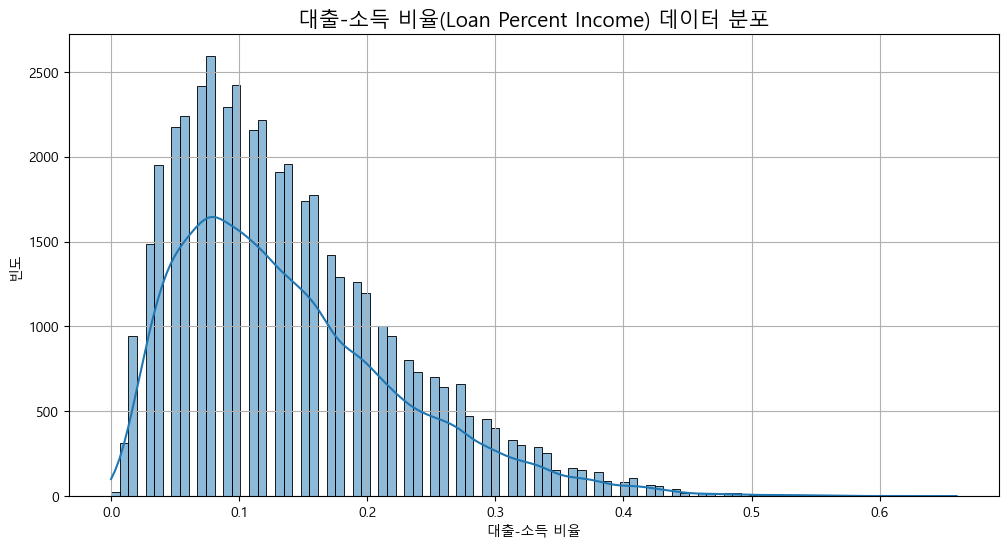

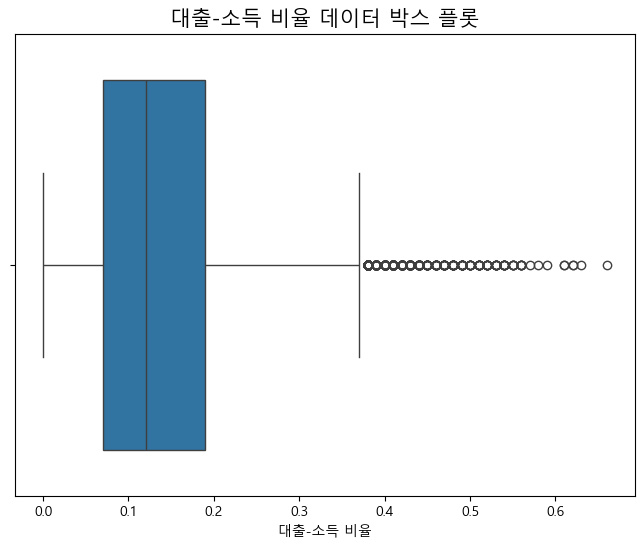

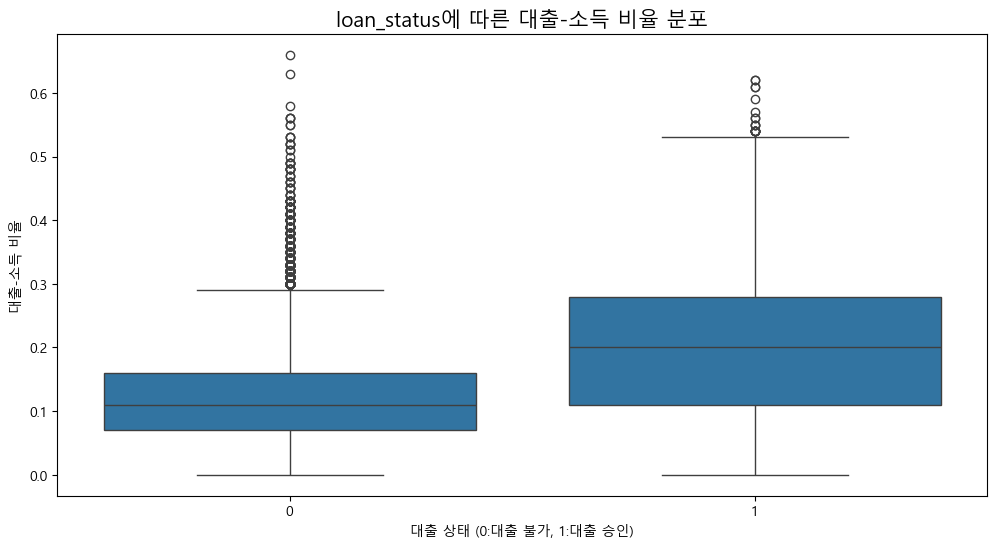

In [45]:
# ----------------------------------------------------
# 3. 데이터 분포 시각화 (히스토그램)
# ----------------------------------------------------
plt.figure(figsize=(12, 6))
sns.histplot(df['loan_percent_income'], kde=True)
plt.title('대출-소득 비율(Loan Percent Income) 데이터 분포', fontsize=15)
plt.xlabel('대출-소득 비율')
plt.ylabel('빈도')
plt.grid(True)
plt.show()

# ----------------------------------------------------
# 4. 이상치 확인 (박스 플롯)
# ----------------------------------------------------
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['loan_percent_income'])
plt.title('대출-소득 비율 데이터 박스 플롯', fontsize=15)
plt.xlabel('대출-소득 비율')
plt.show()

# ----------------------------------------------------
# 5. loan_status 와의 관계 시각화
# ----------------------------------------------------
plt.figure(figsize=(12, 6))
sns.boxplot(x='loan_status', y='loan_percent_income', data=df)
plt.title('loan_status에 따른 대출-소득 비율 분포', fontsize=15)
plt.xlabel('대출 상태 (0:대출 불가, 1:대출 승인)')
plt.ylabel('대출-소득 비율')
plt.show()

In [46]:
# ----------------------------------------------------
# 6. IQR을 이용한 이상치 개수 확인 및 처리
# ----------------------------------------------------
Q1 = df['loan_percent_income'].quantile(0.25)
Q3 = df['loan_percent_income'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치에 해당하는 데이터 개수 확인
outlier_count = df[(df['loan_percent_income'] < lower_bound) | (df['loan_percent_income'] > upper_bound)].shape[0]

print("\n대출-소득 비율 데이터의 이상치 분석 결과")
print(f"이상치 감지 하한선: {lower_bound:.2f}")
print(f"이상치 감지 상한선: {upper_bound:.2f}")
print(f"\n이상치 데이터 개수: {outlier_count}개")

# 이상치 데이터 확인
outliers = df[(df['loan_percent_income'] < lower_bound) | (df['loan_percent_income'] > upper_bound)]
print("\n감지된 이상치 데이터:")
if outliers.empty:
    print("이상치가 발견되지 않았습니다.")
else:
    print(outliers)


대출-소득 비율 데이터의 이상치 분석 결과
이상치 감지 하한선: -0.11
이상치 감지 상한선: 0.37

이상치 데이터 개수: 744개

감지된 이상치 데이터:
       person_age person_gender person_education  person_income  \
0            22.0        female           Master        71948.0   
2            25.0        female      High School        12438.0   
3            23.0        female         Bachelor        79753.0   
4            24.0          male           Master        66135.0   
22           22.0        female           Master        79255.0   
...           ...           ...              ...            ...   
44940        29.0          male      High School        30046.0   
44942        27.0          male           Master        48432.0   
44966        26.0        female         Bachelor        36844.0   
44986        34.0          male         Bachelor        41876.0   
44994        24.0        female        Associate        31924.0   

       person_emp_exp person_home_ownership  loan_amnt        loan_intent  \
0                   0     

## cb_person_cred_hist_length

통계적인 이상치는 발견할 수 있지만, 도메인적으로 이상치라고 보기 어렵다고 생각함. 따라서 특별히 제거하지 않는 방향으로 가는 것이 좋을 것 같음.

추가적으로 대출 여부와 신용 기간이 박스 플롯을 보면 큰 영향이 없는 것 처럼 보임. 이것을 어떻게 해석해야할까? 일반적으로 보면, 신용 기간이 길 수록 대출을 잘 해줄 것 같음.

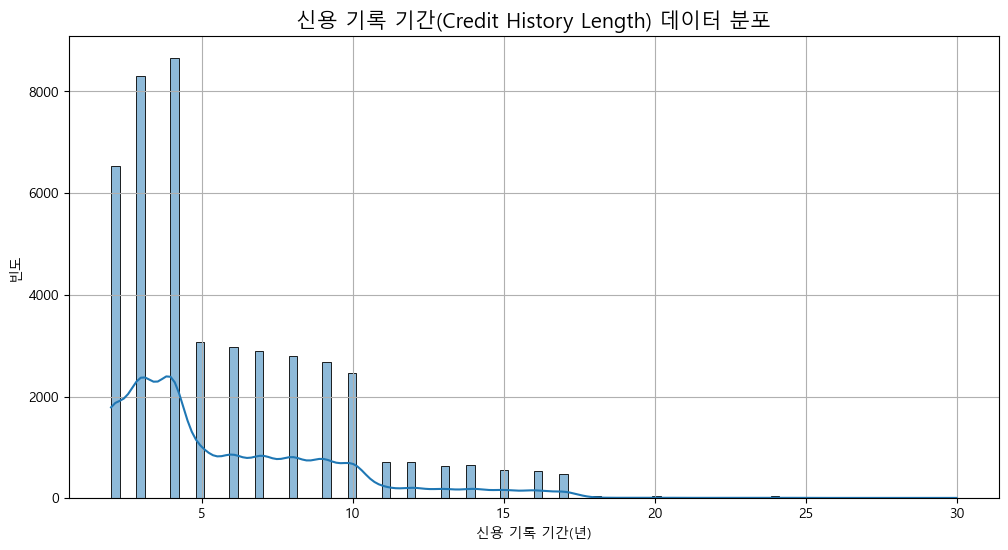

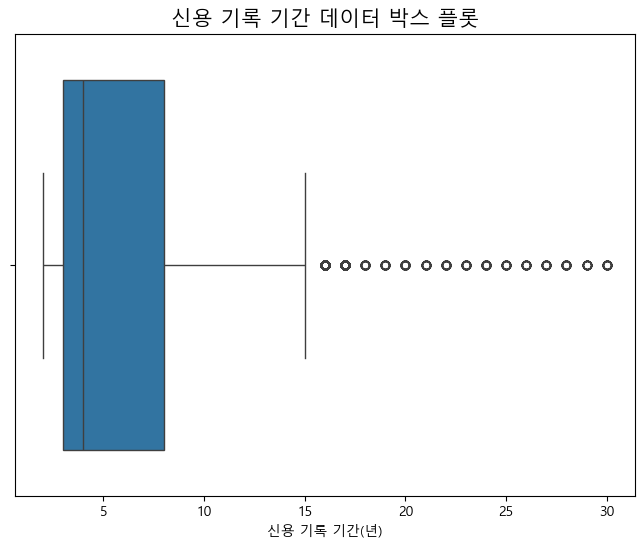

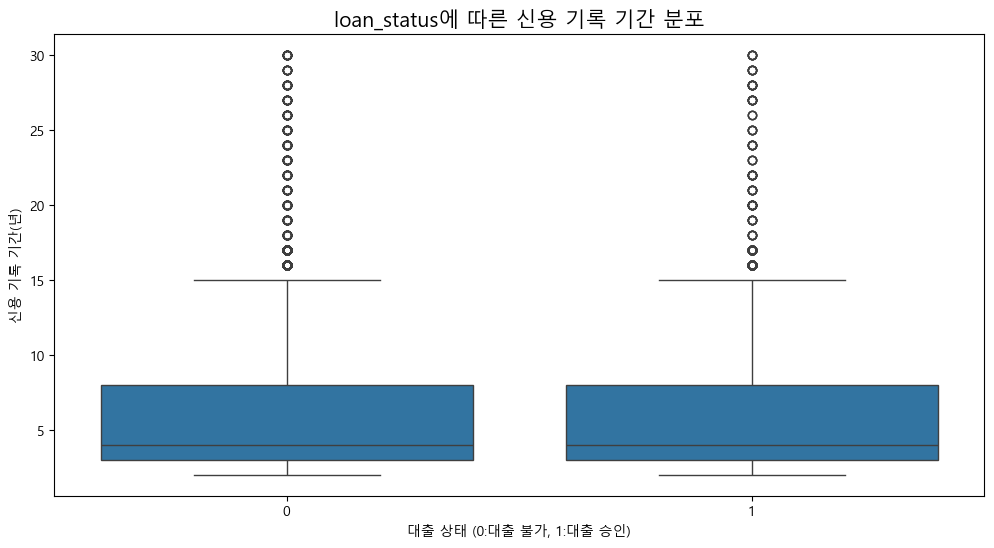

In [48]:
# ----------------------------------------------------
# 3. 데이터 분포 시각화 (히스토그램)
# ----------------------------------------------------
plt.figure(figsize=(12, 6))
sns.histplot(df['cb_person_cred_hist_length'], kde=True)
plt.title('신용 기록 기간(Credit History Length) 데이터 분포', fontsize=15)
plt.xlabel('신용 기록 기간(년)')
plt.ylabel('빈도')
plt.grid(True)
plt.show()

# ----------------------------------------------------
# 4. 이상치 확인 (박스 플롯)
# ----------------------------------------------------
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['cb_person_cred_hist_length'])
plt.title('신용 기록 기간 데이터 박스 플롯', fontsize=15)
plt.xlabel('신용 기록 기간(년)')
plt.show()

# ----------------------------------------------------
# 5. loan_status 와의 관계 시각화
# ----------------------------------------------------
plt.figure(figsize=(12, 6))
sns.boxplot(x='loan_status', y='cb_person_cred_hist_length', data=df)
plt.title('loan_status에 따른 신용 기록 기간 분포', fontsize=15)
plt.xlabel('대출 상태 (0:대출 불가, 1:대출 승인)')
plt.ylabel('신용 기록 기간(년)')
plt.show()

In [49]:
# ----------------------------------------------------
# 6. IQR을 이용한 이상치 개수 확인 및 처리
# ----------------------------------------------------
Q1 = df['cb_person_cred_hist_length'].quantile(0.25)
Q3 = df['cb_person_cred_hist_length'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치에 해당하는 데이터 개수 확인
outlier_count = df[(df['cb_person_cred_hist_length'] < lower_bound) | (df['cb_person_cred_hist_length'] > upper_bound)].shape[0]

print("\n신용 기록 기간 데이터의 이상치 분석 결과")
print(f"이상치 감지 하한선: {lower_bound:.2f}")
print(f"이상치 감지 상한선: {upper_bound:.2f}")
print(f"\n이상치 데이터 개수: {outlier_count}개")

# 이상치 데이터 확인
outliers = df[(df['cb_person_cred_hist_length'] < lower_bound) | (df['cb_person_cred_hist_length'] > upper_bound)]
print("\n감지된 이상치 데이터:")
if outliers.empty:
    print("이상치가 발견되지 않았습니다.")
else:
    print(outliers)


신용 기록 기간 데이터의 이상치 분석 결과
이상치 감지 하한선: -4.50
이상치 감지 상한선: 15.50

이상치 데이터 개수: 1366개

감지된 이상치 데이터:
       person_age person_gender person_education  person_income  \
29120        40.0        female         Bachelor      1440915.0   
29125        37.0          male         Bachelor        97166.0   
29127        44.0          male      High School       703125.0   
29130        37.0        female        Associate       103064.0   
29133        41.0          male        Associate       577228.0   
...           ...           ...              ...            ...   
44627        47.0          male        Doctorate        70131.0   
44705        52.0        female         Bachelor        59758.0   
44734        39.0          male           Master        67306.0   
44923        47.0          male        Associate        46637.0   
44947        42.0          male        Doctorate       705960.0   

       person_emp_exp person_home_ownership  loan_amnt        loan_intent  \
29120              19   

In [50]:
# ----------------------------------------------------
# 7. 이상치 각 값 당 개수 확인 (추가된 코드)
# ----------------------------------------------------
if not outliers.empty:
    print("\n이상치 값별 개수:")
    print(outliers['cb_person_cred_hist_length'].value_counts().sort_index())
else:
    print("\n이상치가 없어 값별 개수를 확인할 수 없습니다.")


이상치 값별 개수:
cb_person_cred_hist_length
16.0    542
17.0    469
18.0     34
19.0     29
20.0     43
21.0     24
22.0     32
23.0     26
24.0     34
25.0     23
26.0     20
27.0     23
28.0     29
29.0     15
30.0     23
Name: count, dtype: int64


## credit_score

신용점수는 터무니 없는 값이 아니라면, 대출 심사에서 중요한 역할을 할 것이라고 판단됨. 제거하지 않는 방향으로 결정

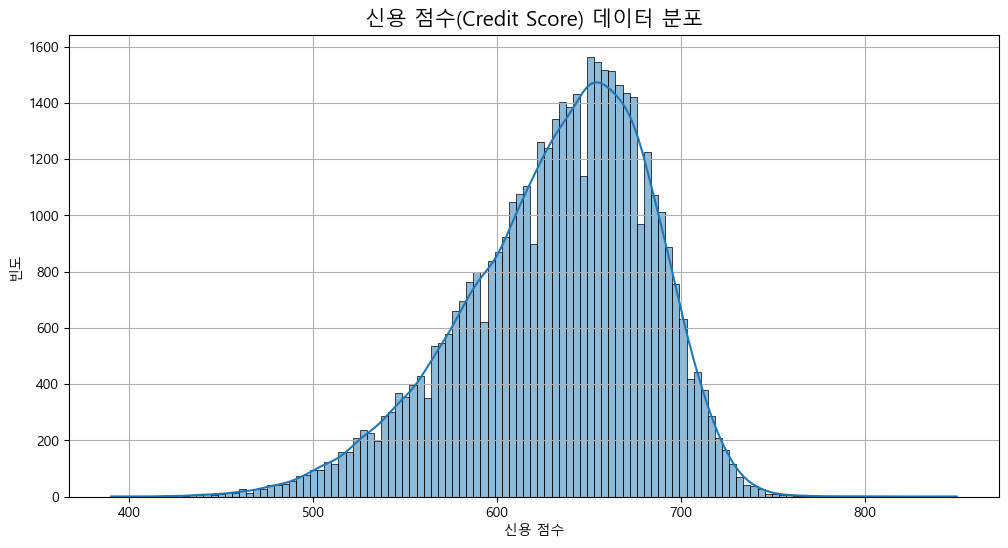

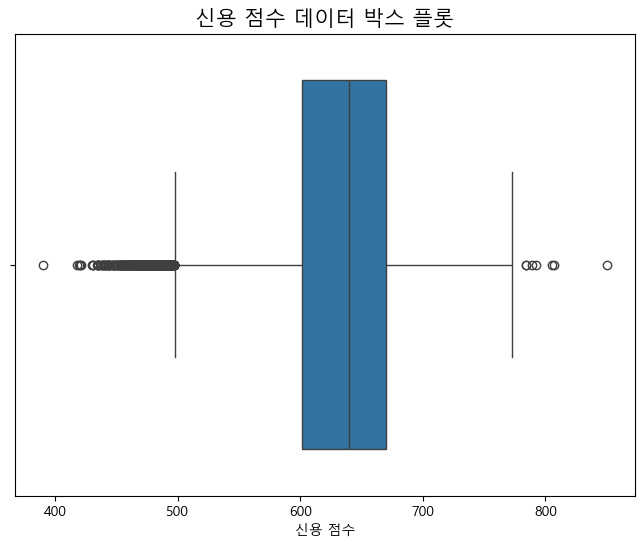

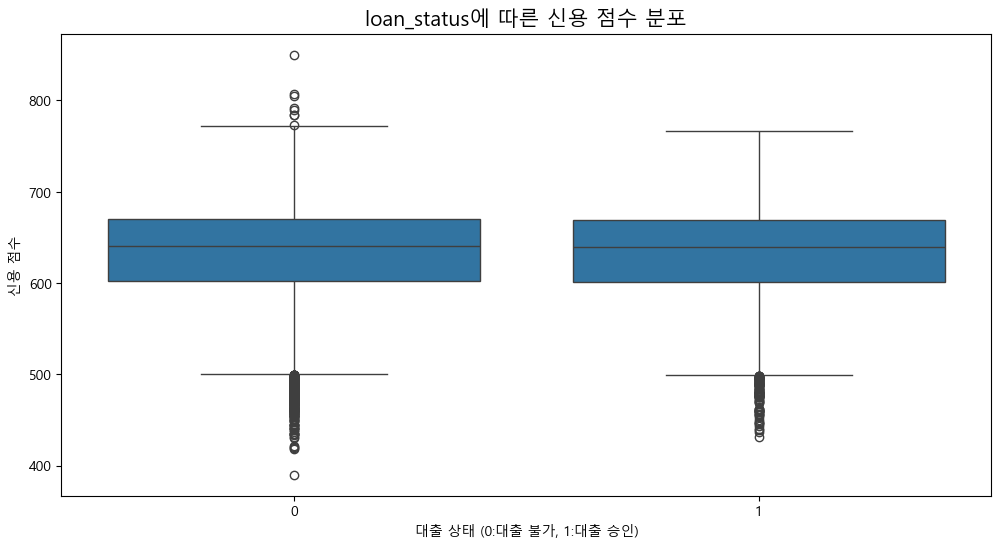

In [51]:
# ----------------------------------------------------
# 3. 데이터 분포 시각화 (히스토그램)
# ----------------------------------------------------
plt.figure(figsize=(12, 6))
sns.histplot(df['credit_score'], kde=True)
plt.title('신용 점수(Credit Score) 데이터 분포', fontsize=15)
plt.xlabel('신용 점수')
plt.ylabel('빈도')
plt.grid(True)
plt.show()

# ----------------------------------------------------
# 4. 이상치 확인 (박스 플롯)
# ----------------------------------------------------
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['credit_score'])
plt.title('신용 점수 데이터 박스 플롯', fontsize=15)
plt.xlabel('신용 점수')
plt.show()

# ----------------------------------------------------
# 5. loan_status 와의 관계 시각화
# ----------------------------------------------------
plt.figure(figsize=(12, 6))
sns.boxplot(x='loan_status', y='credit_score', data=df)
plt.title('loan_status에 따른 신용 점수 분포', fontsize=15)
plt.xlabel('대출 상태 (0:대출 불가, 1:대출 승인)')
plt.ylabel('신용 점수')
plt.show()


In [52]:
# ----------------------------------------------------
# 6. IQR을 이용한 이상치 개수 확인 및 처리
# ----------------------------------------------------
Q1 = df['credit_score'].quantile(0.25)
Q3 = df['credit_score'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치에 해당하는 데이터 개수 확인
outlier_count = df[(df['credit_score'] < lower_bound) | (df['credit_score'] > upper_bound)].shape[0]

print("\n신용 점수 데이터의 이상치 분석 결과")
print(f"이상치 감지 하한선: {lower_bound:.2f}")
print(f"이상치 감지 상한선: {upper_bound:.2f}")
print(f"\n이상치 데이터 개수: {outlier_count}개")

# 이상치 데이터 확인
outliers = df[(df['credit_score'] < lower_bound) | (df['credit_score'] > upper_bound)]
print("\n감지된 이상치 데이터:")
if outliers.empty:
    print("이상치가 발견되지 않았습니다.")
else:
    print(outliers)


신용 점수 데이터의 이상치 분석 결과
이상치 감지 하한선: 497.50
이상치 감지 상한선: 773.50

이상치 데이터 개수: 467개

감지된 이상치 데이터:
       person_age person_gender person_education  person_income  \
81          144.0          male         Bachelor       300616.0   
172          25.0          male      High School        75504.0   
183         144.0          male        Associate       241424.0   
353          23.0        female      High School        19859.0   
575         123.0        female      High School        97140.0   
...           ...           ...              ...            ...   
44618        28.0        female         Bachelor        59767.0   
44676        24.0        female        Associate        37217.0   
44754        25.0          male      High School        86195.0   
44954        25.0        female      High School        19819.0   
44992        23.0        female         Bachelor        40925.0   

       person_emp_exp person_home_ownership  loan_amnt        loan_intent  \
81                125     

## previous_loan_defaults_on_file

특별한 처리를 할 필요는 없다고 판단됨. 그리고 이전 대출 부도 이력이 있으면 100% 확률로 대출 승인이 되지 않는것을 확인

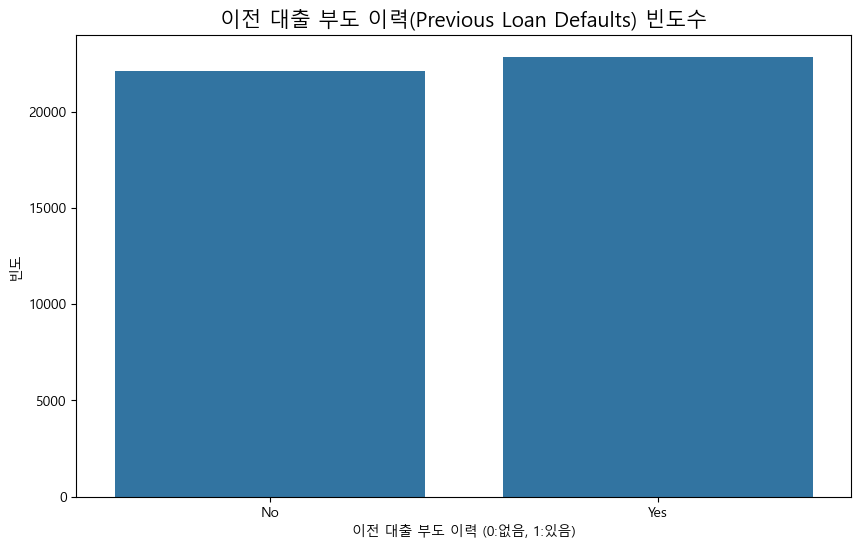

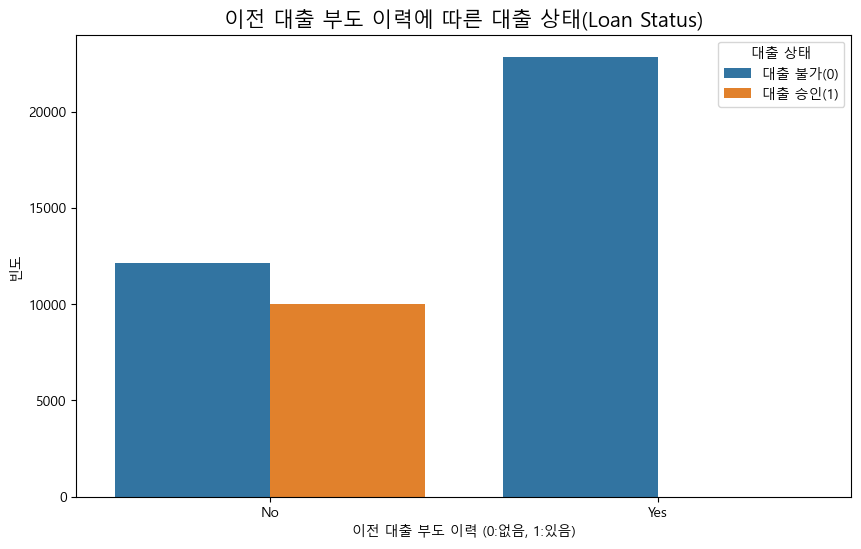

In [53]:
# ----------------------------------------------------
# 3. 데이터 분포 시각화 (막대 그래프)
# ----------------------------------------------------
plt.figure(figsize=(10, 6))
sns.countplot(x='previous_loan_defaults_on_file', data=df)
plt.title('이전 대출 부도 이력(Previous Loan Defaults) 빈도수', fontsize=15)
plt.xlabel('이전 대출 부도 이력 (0:없음, 1:있음)')
plt.ylabel('빈도')
plt.show()

# ----------------------------------------------------
# 4. loan_status 와의 관계 시각화
# ----------------------------------------------------
plt.figure(figsize=(10, 6))
sns.countplot(x='previous_loan_defaults_on_file', hue='loan_status', data=df)
plt.title('이전 대출 부도 이력에 따른 대출 상태(Loan Status)', fontsize=15)
plt.xlabel('이전 대출 부도 이력 (0:없음, 1:있음)')
plt.ylabel('빈도')
plt.legend(title='대출 상태', labels=['대출 불가(0)', '대출 승인(1)'])
plt.show()

## loan_status

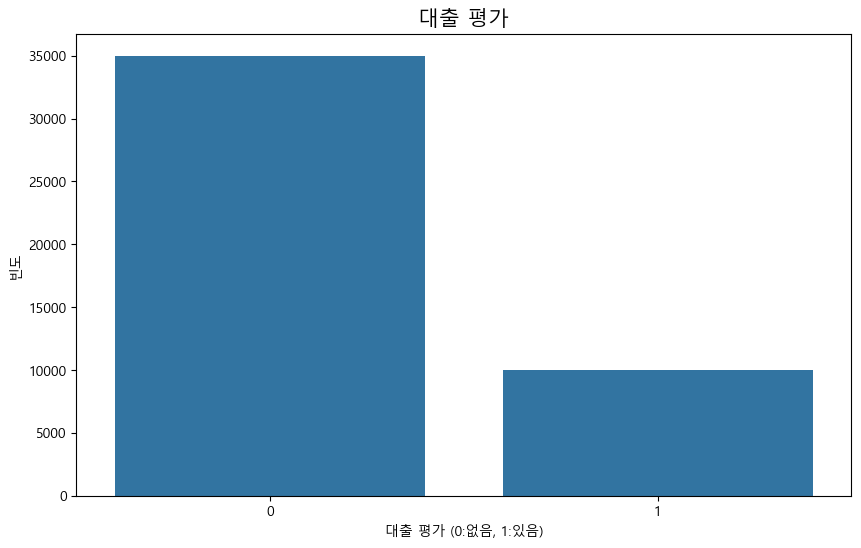

In [54]:
# ----------------------------------------------------
# 3. 데이터 분포 시각화 (막대 그래프)
# ----------------------------------------------------
plt.figure(figsize=(10, 6))
sns.countplot(x='loan_status', data=df)
plt.title('대출 평가', fontsize=15)
plt.xlabel('대출 평가 (0:없음, 1:있음)')
plt.ylabel('빈도')
plt.show()